# Image Rectification
The goal of image rectificiation is to find the Homographies H and H' for the stereo images such that in the transformed image pai, the same world point appears on the same row.

### Import Statements

In [1]:
import cv2
import numpy as np
from scipy.optimize import least_squares
from image_rectification_helper import *

### Load Images

In [2]:
left_file_path = "/Users/wang3450/Desktop/ECE661/HW09/input_images/left.jpg"
right_file_path = "/Users/wang3450/Desktop/ECE661/HW09/input_images/right.jpg"
left_img = cv2.imread(left_file_path, 1)
right_img = cv2.imread(right_file_path, 1)
assert(left_img.shape == right_img.shape)

### Point Correspondences
Purpose: Establish Point 8 point correspondences between left and right image
* x_points (list): list of points in left image
* x_points_prime (list): list of points in right image
* Both lists look like this:
[[x1,y1], [x2,y2], [x3,y3], ..., [x8,y8]]

In [3]:
point_corr_image  = np.hstack((left_img, right_img))
width_adj = right_img.shape[1]
x_points = [[722, 347], [690, 466], [820, 338], [785, 453], [284,487], [280, 463], [477, 191], [622,185]]
x_prime_points = [[618,428], [599, 531], [750, 433], [717, 537], [265,457], [274,430], [505,182], [674,184]]
rainbow = [(211, 0, 148), (130, 0, 75), (255, 0, 0), (0, 255, 0), (0, 255, 255), (0, 127, 255), (0, 0, 255), (0, 0, 0)]

for i in range(len(x_points)):
    left_point = tuple(x_points[i])
    right_point = (x_prime_points[i][0] + width_adj, x_prime_points[i][1])
    cv2.circle(point_corr_image, left_point, 4, rainbow[i], -1)
    cv2.circle(point_corr_image, right_point, 4, rainbow[i], -1)
    cv2.line(point_corr_image, left_point, right_point, rainbow[i], 1)

# cv2.imwrite("point_correspondences.jpg", point_corr_image)

### Normalized 8-point Algorithm for F
Purpose: Given 8 image point correspondences (x, x'), determine the fundamental matrix F

Algorithm:
1. Normalization: Transform the image coordinates to: $\hat x_i = Tx_i$ and $\hat x'_i = T'x'_i$

    T = $\begin{bmatrix}
            s & 0 & -s\bar x\\
            0 & s & -s\bar y\\
            0 & 0 & 1\\
        \end{bmatrix}$
    $\bar x$ and $ \bar y$ : mean of x and y coordinates respectively
    $D$ : list of distances from each point to $(\bar x,\bar y)$
    $\bar D$: mean of D
    $s = \frac{\sqrt 2}{\bar D}\\$

2. Find $\hat F$ from $A \hat F = 0$

   $A \in \mathbb{R}^{8 \times 9}$, $\hat F \in \mathbb{R}^{9}$

3. Constraint Enforcement: Ensure that the rank($\hat F$) = 2

   $\hat F = UDV^T$, $D = diag(r,s,t)$
   $ \hat F' = U diag(r,s,0) V^T$

4. Denormalization: $F = T'^T \hat F' T$

In [4]:
F = compute_F(x_points, x_prime_points)
assert(np.linalg.matrix_rank(F) == 2)
print(f'Fundamental Matrix F: \n{F}')

Fundamental Matrix F: 
[[ 1.35574263e-10  7.36104078e-11 -6.86165608e-05]
 [ 1.82189401e-10 -3.61378824e-11 -1.30055509e-04]
 [ 4.19787748e-05  1.02180418e-04  1.00000000e+00]]


### Estimate the Left and Right Epipoles
$F\vec e = 0$
<br>
$\vec e'^T F = 0$

$\therefore \vec e $ is the right null vector and $\vec e'$ is the left null vector of $F$


In [5]:
e, e_prime = compute_e(F)
print(f'left epipole e: {e}')
print(f'right epipole e\': {e_prime}')

left epipole e: [ 6.58264939e+05 -2.80221557e+05  1.00000000e+00]
right epipole e': [-1.09955053e+06  5.87805748e+05  1.00000000e+00]


### Obtain the Initial Estimate of the Projection Matrices in Canonical From
$P =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
\end{bmatrix}$
;
$P' =
\begin{bmatrix}
[e']_x & F & |e'\\
\end{bmatrix}$
;
$[e']_x =
\begin{bmatrix}
0 & -e'_3 & e'_2\\
e'_3 & 0 & -e'_1\\
-e'_2 & e'_1 & 0\\
\end{bmatrix}$

In [6]:
P, P_prime = compute_P(e_prime, F)
print(f'P: \n {P}\n')
print(f'P\': \n {P_prime}')

P: 
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]

P': 
 [[ 2.46753651e+01  6.00622368e+01  5.87805748e+05 -1.09955053e+06]
 [ 4.61577840e+01  1.12352532e+02  1.09955053e+06  5.87805748e+05]
 [-2.80017783e-04 -3.53319325e-06  1.83335812e+02  1.00000000e+00]]


### Perform Triangulation to find World Points from (x,x') correspondences
$A \vec X = \vec 0 \rightarrow
\begin{bmatrix}
xP_3^T - P_1^T \\
yP_3^T - P_2^T \\
x'P'_3^T - P'_1^T \\
y'P'_3^T - P'_2^T \\
\end{bmatrix}
\begin{bmatrix}
X_x\\ X_y \\ X_z \\ X_w\\
\end{bmatrix} =
\begin{bmatrix}
0 \\ 0 \\ 0 \\ 0\\
\end{bmatrix}$

$A \in \mathbb{R}^{4 \times 4}$ ; $X \in \mathbb{R}^{4}$

$X$ is given by the smallest eigenvector of $A^TA$

In [7]:
world_points = [triangulate(P, P_prime, x_points[i], x_prime_points[i]) for i in range(len(x_points))]
for i, wp in enumerate(world_points):
    print(f'World Point {i+1}: {wp}')

World Point 1: [-357284.32909888646, 326954.0579582923, -20.358602669401375]
World Point 2: [-580460.4280951299, 460159.3828964455, -25.353510761309558]
World Point 3: [-241474.83993563862, 232629.25928513843, -15.24171215893636]
World Point 4: [-366956.46024573746, 310825.50747577107, -18.496589879343993]
World Point 5: [-50811765.515655145, 24993675.94451429, -449.7800609342888]
World Point 6: [-20838609.27581754, 10453084.059552195, -206.3857652243492]
World Point 7: [-309616.9655737378, 306080.5769663117, -19.38672025250861]
World Point 8: [-187689.93976001235, 201780.2074281931, -13.684626623203963]


### Refinement of P'
* params contains p' and every 3-vector world point
* cost function minimizes: $\sum_i|| x_i - \hat x_i||^2 + ||x'_i - \hat x'_i||$ where $\hat x$ are the world points reprojected into the respective image frames

In [8]:
'''pack p' into params'''
params = np.zeros(12 + (3 * len(x_points)))
params[0:12] = np.reshape(P_prime, 12)
params[12:]=np.reshape(world_points,(3*len(x_points)))

In [9]:
optim = least_squares(cost_function, params, args=(x_points,x_prime_points), verbose =1)
params_star = optim['x']

`ftol` termination condition is satisfied.
Function evaluations 1824, initial cost 1.6001e+10, final cost 9.7667e+04, first-order optimality 1.74e+01.


In [10]:
P_prime_ref = params_star[0:12]
P_prime_ref = np.reshape(P_prime_ref, (3,4))

t_ref = P_prime_ref[:,-1]
t_ref_matrix = np.array([[0, -t_ref[2], t_ref[1]], [t_ref[2], 0, -t_ref[0]], [-t_ref[1], t_ref[0], 0]])
F_ref = t_ref_matrix@P_prime[:,0:3]
F_ref = F_ref / F_ref[-1,-1]
_, e_prime_ref = compute_e(F_ref)
print(f'Refined F: \n{F_ref}')
print(f'P: \n{P}')
print(f'Refined P\' \n{P_prime_ref}' )
print(f'Refined e\': \n {e_prime_ref}')

Refined F: 
[[ 4.76284975e-06  1.15929854e-05  1.13387409e-01]
 [-2.54590433e-06 -6.19745956e-06 -6.07822061e-02]
 [ 4.19787748e-05  1.02180418e-04  1.00000000e+00]]
P: 
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
Refined P' 
[[-1.37840115e+07  2.34749810e+07  1.57294430e+07 -2.66047266e+07]
 [ 6.40307024e+06 -1.09037472e+07 -6.19440597e+06  1.40364794e+07]
 [-1.78831773e+04  3.04498331e+04  2.35542310e+04  3.86980920e+06]]
Refined e': 
 [-6.8749453  3.6271761  1.       ]


### Rectifying the Right Image
1. Compute the Translation Matrix which sends the image center to origin

    $T_1 = \begin{bmatrix}
    1 & 0 & -x_0\\
    0 & 1 & -y_0\\
    0 & 0 & 1\\
    \end{bmatrix}$

    $(x_0, y_0)$ is the center of the right image
2. Compute the Rotation Matrix which rotates the translated right epipole to $\begin{bmatrix} f & 0 & 1 \end{bmatrix}^T$

    $R = \begin{bmatrix}
    \cos{t} & -\sin{t} & 0\\
    \sin{t} & \cos{t} & 0\\
    0 & 0 & 1\\
    \end{bmatrix}$

3. Compute G Matrix which sends the epipole to $\infty$

    $G = \begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    -1/f & 0 & 1\\
   \end{bmatrix}$

4. Compute the Translational Matrix which makes the upper left corner the orgin

    $T_2 = \begin{bmatrix}
    1 & 0 & x_0\\
    0 & 1 & y_0\\
    0 & 0 & 1\\
    \end{bmatrix}$

    $(x_0, y_0)$ is the center of the right image

5. The homography that rectifies the right image is: $H' = T_2GRT$

In [11]:
H_prime, f = get_H_prime(right_img, e_prime_ref)
H_prime = H_prime / H_prime[-1,-1]
print(f'H\': \n {H_prime}')
print(f'f: \n{f}')

H': 
 [[ 8.25954849e-02  6.05265637e-02  1.88171325e+02]
 [-5.37685087e-01  2.27529793e-01  3.74495890e+02]
 [-6.38480255e-04 -4.67882910e-04  1.00000000e+00]]
f: 
633.362629943494


### Rectifying the Left Image
1. Find $M = P'P^{\dagger}$
    Note: $P^{\dagger}$ is the right pseudoinverse of P

2. Set $H_0 = H'M$
3. Transform points in both the left and right images i.e (x, x') using $H_0$ and H' such that:
   $\hat x = H_0 x$
   $\hat x' = H'x'$
4. Then we use the transformed coordinates to set up a distance min problem to address the issue of scaling the left image to match up to the right image as follows:

    $H_a = \begin{bmatrix}
    a & b & c\\
    0 & 1 & 0\\
    0 & 0 & 1\\
    \end{bmatrix}$

    a, b, and c are determine by the min problem:
    $min_{a,b,c}\sum_i(a \hat x_i + b \hat y_i + c - \hat x'_i)^2$

    which simplifies to $min_x ||Ax-b||^2$

    $A = \begin{bmatrix}
    \hat x_1 & \hat y_1 & 1\\
    \hat x_2 & \hat y_2 & 1\\
    \dots & \dots & \dots\\
    \end{bmatrix}$

    $b = \begin{bmatrix}
    \hat x'_1\\
    \hat x'_2\\
    \dots
    \end{bmatrix}$

5. The homography that rectifies the left image is: $H = H_a H_0$

In [12]:
H, H_0 = get_H(P, P_prime_ref, H_prime, x_points, x_prime_points)
H = H / H[-1][-1]
H_0 = H_0 / H_0[-1][-1]

print(f'H: \n{H}')
print(f'H_0: \n{H_0}')

Ha: 
[[-3.46906770e+02  1.27441436e+02  1.41727875e+05]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
H: 
[[-4.41449133e+02  7.00625027e+02  2.03658086e+04]
 [ 1.32311394e+02 -2.25462457e+02 -6.37394812e+01]
 [-7.36049802e-01  1.25312392e+00  1.00000000e+00]]
H_0: 
[[-250.83215075  427.1139059   326.42492201]
 [ 132.31139379 -225.46245733  -63.73948117]
 [  -0.7360498     1.25312392    1.        ]]


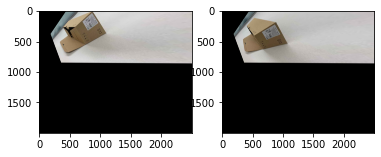

In [17]:
w, h = 2500, 2000
from matplotlib import pyplot as plt
def rectification_plot (image1,image2,H, Hp, w, h, save_img_path):
    rectified1 = cv2.warpPerspective(image1, Hp, (w, h))
    rectified2 = cv2.warpPerspective(image2, (Hp), (w, h))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(rectified1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(rectified2, cv2.COLOR_BGR2RGB))
    plt.savefig(save_img_path,dpi=1200)
    return rectified1 , rectified2

# H =np.array([[-7.13781513e+00,  2.86260684e+01,  2.10576556e+02],
#  [-1.28237139e+01 , 5.16282910e+01 , 3.74581045e+02],
#  [-3.40561613e-02 , 1.36831769e-01,  1.00000000e+00]])
# print(H)
rec1, rec2 = rectification_plot(left_img, right_img, H, H_prime, w, h, '/Users/wang3450/Desktop/ECE661/test_hw09/test.jpg')

In [14]:
# test = transformInputImage(left_img, H_prime)
# cv2.imshow('test', test)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
